Welcome. This model is called ... rec_sz1


WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 3. s
1.2143 s (40%) simulated in 10s, estimated 15s remaining.
2.3578 s (78%) simulated in 20s, estimated 5s remaining.
3. s (100%) simulated in 25s


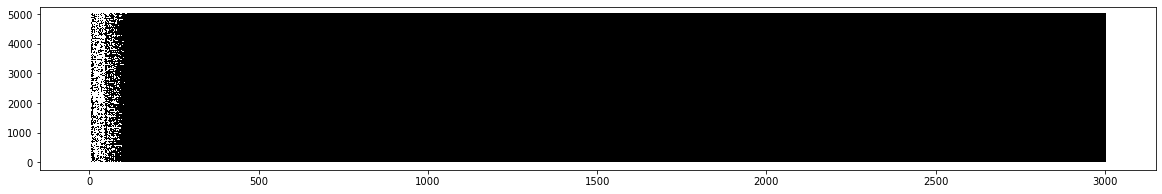

average spiking rate of population:  480.7292666666666 Hz


In [1]:
location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)

# import statements
from brian2 import *
from funcs_pj import generate_new_color
import matplotlib.pyplot as plt
import numpy as np
from brian2_recurrentnet_seizures.brian2_utils import *
from brian2_recurrentnet_seizures.brian_recurrent_net_main import *

import pickle
import pandas as pd


WARNING    "dt" is an internal variable of group "poissongroup_1", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
1.2654 s (25%) simulated in 10s, estimated 30s remaining.
2.4878 s (49%) simulated in 20s, estimated 20s remaining.
3.7037 s (74%) simulated in 30s, estimated 11s remaining.
4.939 s (98%) simulated in 40s, estimated < 1s remaining.
5. s (100%) simulated in 40s


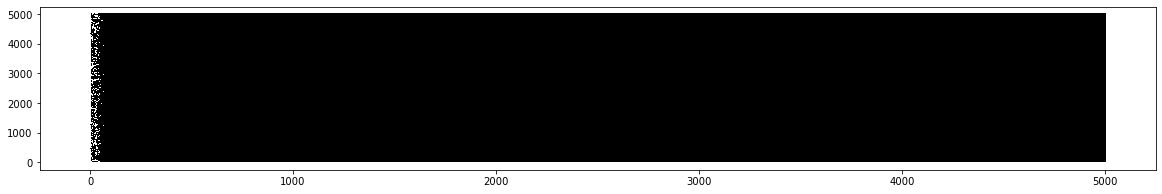

average spiking rate of population:  492.7612799999999 Hz


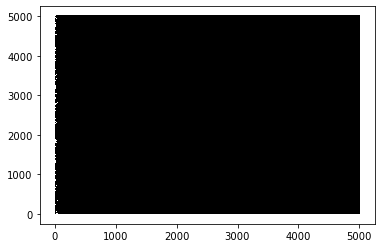

In [2]:
#%% BUILD AND RUN NETWORK
runtime = 5*second
dt = 0.1*ms

# build network
record_id=[100, 4000, 2300, 3049, 494, 209, 250, 1505]
net, trace, s_mon, trace_ge, s_mon_p, Ce, Ci, Ge, Gi, G, trace_z, trace_gi, trace_gi_diff = build_network(record_id=record_id, inh_conn=0.2)

# run simulation
net.run(runtime, report='text')

# quick spike raster plot to initialize plotting
figure(figsize=[20,3])
plot(s_mon.t/ms, s_mon.i, ',k'); plt.show()
spike_counts = s_mon.count
spike_counts_Hz = array(spike_counts/runtime)
avg=mean(spike_counts_Hz); print('average spiking rate of population: ', avg, 'Hz')

plt.plot(s_mon.t/ms, array(s_mon.i), ',k')
plt.show()
